In [11]:
# Imports
import os, sys

# pandas
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

#keras
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Input, concatenate, Flatten, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
sys.path.append('../../lotufo')
from my_keras_utilities import (get_available_gpus, load_model_and_history, save_model_and_history, TrainingPlotter)

In [60]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        
def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  shuffle=True,
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval),
                      shuffle=shuffle,
                      callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

## Load data

In [61]:
titanic_train = pd.read_csv('../Data/train.csv')
titanic_test = pd.read_csv('../Data/test.csv')

# print(titanic_train.info())
# print('-'*100)
# print(titanic_test.info())
# # titanic_train.head(-1)

## Remove not interesting data

##### remove data that should not be relevant to the prediction

In [62]:
# titanic_train = titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
titanic_train = titanic_train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
# titanic_test = titanic_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_test = titanic_test.drop(['Ticket', 'Cabin'], axis=1)
print(titanic_train.info())
print('-'*100)
print(titanic_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int6

## Filling empty data

##### fill missing Fare and the missing Ages based on the person title ( miss, mrs, mr, etc.)

In [63]:
# miss, mrs, mr, master
age = titanic_train.Age.as_matrix().copy()

aux = (titanic_train.Name.str.find('Miss.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 20 #'young'
aux = (titanic_train.Name.str.find('Mr.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_train.Name.str.find('Mrs.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_train.Name.str.find('Master.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 5 #'kids'
aux = (titanic_train.Name.str.find('Dr.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
aux = (titanic_train.Name.str.find('Ms.') > 0) * (1-titanic_train.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
titanic_train.Age = age

age = titanic_test.Age.as_matrix().copy()
aux = (titanic_test.Name.str.find('Miss.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 20 #'young'
aux = (titanic_test.Name.str.find('Mr.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_test.Name.str.find('Mrs.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 30 #'adult'
aux = (titanic_test.Name.str.find('Master.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 5 #'kids'
aux = (titanic_test.Name.str.find('Dr.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
aux = (titanic_test.Name.str.find('Ms.') > 0) * (1-titanic_test.Age.notnull())
age[np.where(aux == 1)[0]] = 40 #'adult'
titanic_test.Age = age



titanic_test.Fare[np.asarray(np.where(np.isnan(titanic_test.Fare.as_matrix()))).reshape(1)] = 10

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
titanic_test.Parch[np.asarray(np.where(titanic_test.Parch.as_matrix() == 6)).reshape(1)] = 5

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Remove rows with missing data

###### remove (just a few) rows that are missing Embarked information

In [65]:
# titanic_train = titanic_train[titanic_train.Age.notnull()]
# titanic_test = titanic_test[titanic_test.Age.notnull()]

titanic_train = titanic_train[titanic_train.Embarked.notnull()]
# titanic_test = titanic_test[titanic_test.Embarked.notnull()]

# titanic_train = titanic_train[titanic_train.Fare.notnull()]
# titanic_test = titanic_test[titanic_test.Fare.notnull()]

print(titanic_train.info())
print('-'*100)
print(titanic_test.info())
titanic_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int6

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,S


## Catogorize and normalize data

###### Caterorize ages in 5 ranges

In [8]:
Age_norm_train_cat = titanic_train.Age.as_matrix()
Age_norm_train_cat[Age_norm_train_cat <= 10] = 0 #'kids'
Age_norm_train_cat[(Age_norm_train_cat > 10) * (Age_norm_train_cat <= 20)] = 1 #'teen'
Age_norm_train_cat[(Age_norm_train_cat > 20) * (Age_norm_train_cat <= 30)] = 2 #'young'
Age_norm_train_cat[(Age_norm_train_cat > 30) * (Age_norm_train_cat <= 55)] = 3 #'adult'
Age_norm_train_cat[(Age_norm_train_cat > 55)] = 4 #'old'
# Age_norm_train_cat


Age_norm_test_cat = titanic_test.Age.as_matrix()
Age_norm_test_cat[Age_norm_test_cat <= 10] = 0 #'kids'
Age_norm_test_cat[(Age_norm_test_cat > 10) * (Age_norm_test_cat <= 18)] = 1 #'teen'
Age_norm_test_cat[(Age_norm_test_cat > 18) * (Age_norm_test_cat <= 30)] = 2 #'young'
Age_norm_test_cat[(Age_norm_test_cat > 30) * (Age_norm_test_cat <= 55)] = 3 #'adult'
Age_norm_test_cat[(Age_norm_test_cat > 55)] = 4 #'old'

## Normalize categorical data

In [66]:
#train
Pclass_classes_train, Pclass_norm_train = np.unique(titanic_train.Pclass.as_matrix(), return_inverse=True)
Sex_classes_train, Sex_norm_train = np.unique(titanic_train.Sex.as_matrix(), return_inverse=True)
# Age_classes_train, Age_norm_train_cat = np.unique(Age_norm_train_cat, return_inverse=True)
#
SibSp_classes_train, SibSp_norm_train = np.unique(titanic_train.SibSp.as_matrix(), return_inverse=True)
Parch_classes_train, Parch_norm_train = np.unique(titanic_train.Parch.as_matrix(), return_inverse=True)
#
Embarked_classes_train, Embarked_norm_train = np.unique(titanic_train.Embarked.as_matrix(), return_inverse=True)

#test
Pclass_classes_test, Pclass_norm_test = np.unique(titanic_test.Pclass.as_matrix(), return_inverse=True)
Sex_classes_test, Sex_norm_test = np.unique(titanic_test.Sex.as_matrix(), return_inverse=True)
# Age_classes_test, Age_norm_test_cat = np.unique(Age_norm_test_cat, return_inverse=True)
#
SibSp_classes_test, SibSp_norm_test = np.unique(titanic_test.SibSp.as_matrix(), return_inverse=True)
Parch_classes_test, Parch_norm_test = np.unique(titanic_test.Parch.as_matrix(), return_inverse=True)
#
Embarked_classes_test, Embarked_norm_test = np.unique(titanic_test.Embarked.as_matrix(), return_inverse=True)


## Normalize non categorical data

In [68]:
#train
Age_norm_train = titanic_train.Age.as_matrix()
Age_max = np.max(Age_norm_train)
Age_norm_train = Age_norm_train / Age_max

# SibSp_norm_train = titanic_train.SibSp.as_matrix()
# SibSp_max = np.max(SibSp_norm_train)
# SibSp_norm_train = SibSp_norm_train / SibSp_max

# Parch_norm_train = titanic_train.Parch.as_matrix()
# Parch_max = np.max(Parch_norm_train)
# Parch_norm_train = Parch_norm_train / Parch_max

Fare_norm_train = titanic_train.Fare.as_matrix()
Fare_max = np.max(Fare_norm_train)
Fare_norm_train = Fare_norm_train / Fare_max

#test (use the same normalization)
Age_norm_test = titanic_test.Age.as_matrix()
Age_norm_test = Age_norm_test / Age_max

# SibSp_norm_test = titanic_test.SibSp.as_matrix()
# SibSp_norm_test = SibSp_norm_test / SibSp_max

# Parch_norm_test = titanic_test.Parch.as_matrix()
# Parch_norm_test = Parch_norm_test / Parch_max

Fare_norm_test = titanic_test.Fare.as_matrix()
Fare_norm_test = Fare_norm_test / Fare_max

# Build Keras Model

In [109]:
#Survived Pclass Sex Age SibSp Parch Fare Embarked
def build_keras_model():
    Pclass_in = Input(shape=(1,), dtype='int64', name='Pclass_in')
    x = Embedding(Pclass_classes_train.size, 2, input_length=1, name='Pclass_embedding')(Pclass_in)
    Pclass_emb = Flatten(name='Pclass_flatten')(x)
    
    Sex_in = Input(shape=(1,), name='Sex_in')
    Sex_out = Dense(2, input_dim=1)(Sex_in)
    
    Age_in = Input(shape=(1,), name='Age_in')
    Age_out = Dense(1, input_dim=1)(Age_in)
#     Age_in = Input(shape=(1,), dtype='int64', name='Age_in')
#     x = Embedding(Age_classes_train.size, 4, input_length=1, name='Age_embedding')(Age_in)
#     Age_emb = Flatten(name='Age_flatten')(x)
    
#     SibSp_in = Input(shape=(1,), name='SibSp_in')
#     SibSp_out = Dense(1, input_dim=1)(SibSp_in)
    SibSp_in = Input(shape=(1,), dtype='int64', name='SibSp_in')
    x = Embedding(SibSp_classes_train.size, 3, input_length=1, name='SibSp_embedding')(SibSp_in)
    SibSp_out = Flatten(name='SibSp_flatten')(x)
    
#     Parch_in = Input(shape=(1,), name='Parch_in')
#     Parch_out = Dense(1, input_dim=1)(Parch_in)
    Parch_in = Input(shape=(1,), dtype='int64', name='Parch_in')
    x = Embedding(Parch_classes_train.size, 3, input_length=1, name='Parch_embedding')(Parch_in)
    Parch_out = Flatten(name='Parch_flatten')(x)
    
    Fare_in = Input(shape=(1,), name='Fare_in')
    Fare_out = Dense(2, input_dim=1)(Fare_in)
    
    Embarked_in = Input(shape=(1,), dtype='int64', name='Embarked')
    x = Embedding(Embarked_classes_test.size, 2, input_length=1, name='Embarked_embedding')(Embarked_in)
    Embarked_emb = Flatten(name='Embarked_flatten')(x)
    
    
    xin = concatenate([Pclass_emb, Sex_out, Age_out, SibSp_out, Parch_out, Fare_out, Embarked_emb])
#     xin = concatenate([Pclass_emb, Sex_out, Age_emb, SibSp_out, Parch_out, Fare_out, Embarked_emb])
    x = Dense(100, kernel_initializer='random_normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001))(xin)
    x = Dropout(0.8)(x)
    x = Dense(50, kernel_initializer='random_normal', activation='relu')(xin)
    x = Dropout(0.5)(x)
    x = Dense(10, kernel_initializer='random_normal', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
    x_out = Dense(1, activation='sigmoid')(x)
    
    return Model([Pclass_in, Sex_in, Age_in, SibSp_in, Parch_in, Fare_in, Embarked_in], x_out)

model_ti = build_keras_model()
model_ti.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Pclass_in (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
SibSp_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
Parch_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
Embarked (InputLayer)            (None, 1)             0                                            
___________________________________________________________________________________________

# Show the model

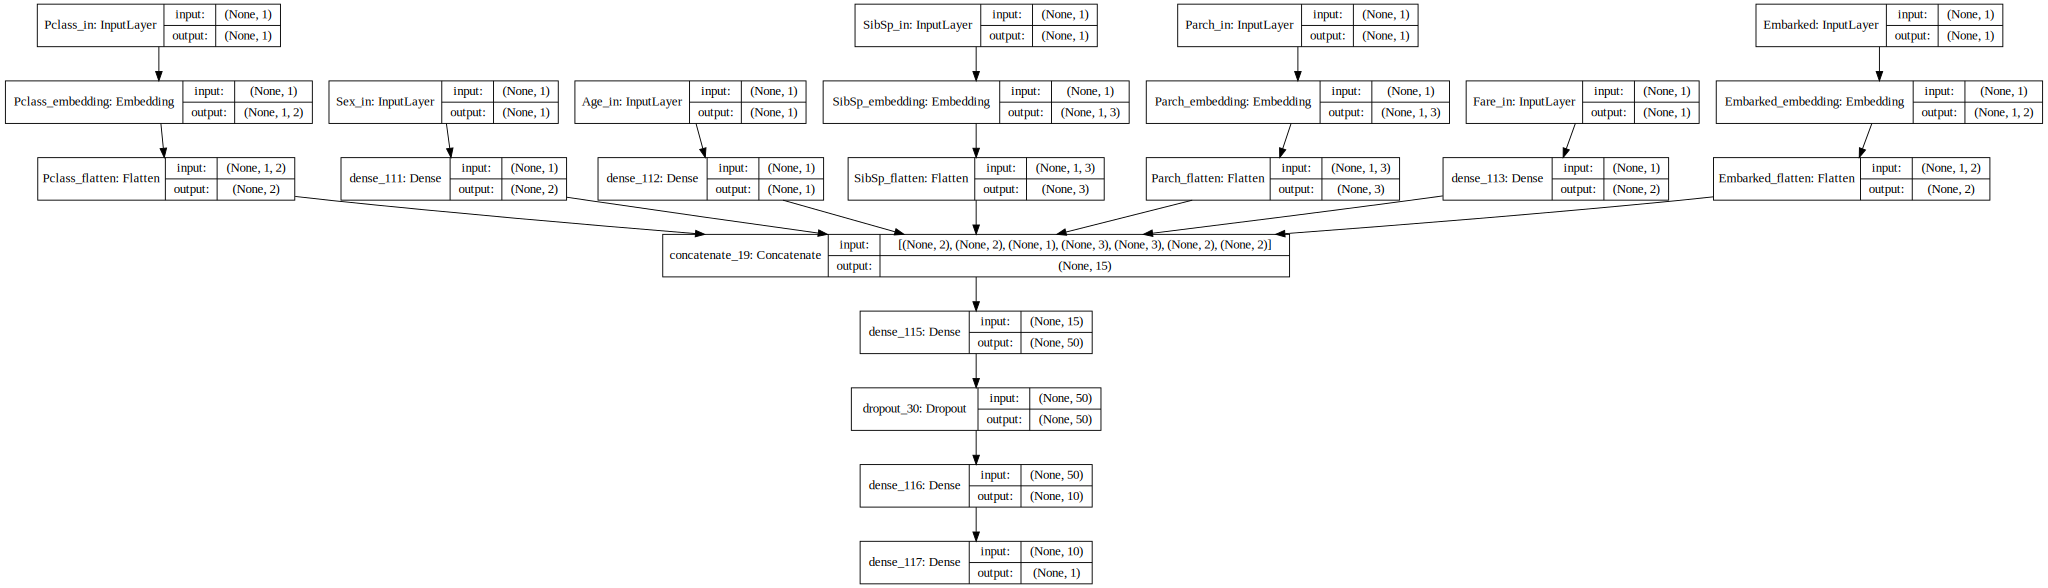

In [86]:
# from keras.utils import plot_model
# plot_model(model_ti, to_file='model_ti.png', show_shapes=True)
# # print pydot.find_graphviz()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_ti, show_shapes=True).create(prog='dot', format='svg'))

# Create validation data from the train data

In [110]:
num_records = len(titanic_train['Survived'].as_matrix())
train_ratio = 0.75
train_size = int(train_ratio * num_records)


# Age as non categoriacal
# X_train_p = [Pclass_norm_train[:train_size], Sex_norm_train[:train_size], Age_norm_train[:train_size],
#              SibSp_norm_train[:train_size], Parch_norm_train[:train_size],
#              Fare_norm_train[:train_size], Embarked_norm_train[:train_size]]
# y_train = titanic_train['Survived'].as_matrix()[:train_size]

# X_val_p = [Pclass_norm_train[train_size:], Sex_norm_train[train_size:], Age_norm_train[train_size:],
#              SibSp_norm_train[train_size:], Parch_norm_train[train_size:],
#              Fare_norm_train[train_size:], Embarked_norm_train[train_size:]]
# y_val = titanic_train['Survived'].as_matrix()[train_size:]

# Age as categoriacal
X_train_p = [Pclass_norm_train[:train_size], Sex_norm_train[:train_size], Age_norm_train_cat[:train_size],
             SibSp_norm_train[:train_size], Parch_norm_train[:train_size],
             Fare_norm_train[:train_size], Embarked_norm_train[:train_size]]
y_train = titanic_train['Survived'].as_matrix()[:train_size]

X_val_p = [Pclass_norm_train[train_size:], Sex_norm_train[train_size:], Age_norm_train_cat[train_size:],
             SibSp_norm_train[train_size:], Parch_norm_train[train_size:],
             Fare_norm_train[train_size:], Embarked_norm_train[train_size:]]
y_val = titanic_train['Survived'].as_matrix()[train_size:]

# Train the model

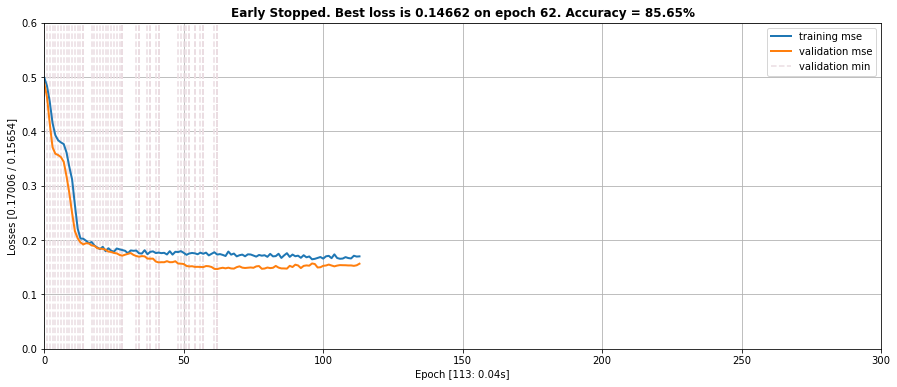

In [111]:
model_name = 'model_ti_02'
fit_params = {
    'model_name': model_name,
    'loss': 'mean_absolute_error',
    'opt':        Adam(lr=0.003), 
    'batch_size': 30, 
    'nepochs':    300,
    'patience':   50, 
    'ploss':      0.6,
    'shuffle':    False,
    'reset':      True,
}

train_network(model_ti, X_train_p, y_train, X_val_p, y_val, **fit_params);

# Evaluate the model

In [105]:
loss = model_ti.evaluate(X_val_p, y_val, verbose=0)
print('Final loss:',loss)

W = model_ti.get_weights()
print('Bias:\n', W[1])
print('W:\n', W[0])

Y_hat = model_ti.predict(X_val_p)
accuracy = sum((Y_hat.reshape(len(y_val))>0.5) == y_val)/(float(len(y_val)))
accuracy

Final loss: [0.13775312917286089, 0.86516853731669741]
Bias:
 [[-0.19165319 -0.39245632 -0.36334369]
 [-0.28501859  0.09120644  0.03876012]
 [ 0.14951046  0.12754916  0.12206843]
 [ 0.46801239  0.53880173  0.47163931]
 [ 0.62444037  0.59116852  0.64827579]
 [ 0.33437717  0.44444108  0.5424754 ]
 [ 0.34932888  0.35704839  0.38289371]]
W:
 [[ 0.42342794  0.47198305]
 [ 0.43789878  0.46600187]
 [-0.35084504 -0.31232491]]


0.8651685393258427

# Predict

In [98]:
# X_test = list(np.array([Pclass_norm_test, Sex_norm_test, Age_norm_test_cat,
#              SibSp_norm_test, Parch_norm_test,
#              Fare_norm_test, Embarked_norm_test]).reshape(7,418,1))
# X_test = [Pclass_norm_test, Sex_norm_test, Age_norm_test_cat,
# 

X_test = [Pclass_norm_test, Sex_norm_test, Age_norm_test_cat, SibSp_norm_test, Parch_norm_test, Fare_norm_test, Embarked_norm_test]
# model_ti.predict(X_test)
Y_test = model_ti.predict(X_test) > 0.5
Y_test.reshape((len(Y_test),)) 
Y_test = np.squeeze(Y_test) * 1
Y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [99]:
my_prediction = pd.DataFrame({'PassengerId':titanic_test['PassengerId'].values,'Survived':Y_test})
# my_prediction.to_csv("my_prediction.csv")
my_prediction.to_csv("my_prediction_3.csv")

In [100]:
my_prediction

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
